<a href="https://colab.research.google.com/github/Arrancara/MachineLearningGUH2021/blob/main/Booking_com_Challenge_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*This is the Booking.com challenge to model the wait times for users arriving at a certain destination. This model is split into two sections, where it can predict what the expected wait time at security at a certaina airport is on a given day. It then predicts the time taken to get to the car rental shop after arriving from the airport.*

*The total wait time is the sum of these times".


**General**
Applicable to both models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision = 3, suppress = True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
data_filepath = "/content/drive/MyDrive/Booking Challenge/car_rentals_large.csv"
airport_data_filepath  = "/content/drive/MyDrive/Booking Challenge/airports_codes.csv"


column_names_rentals = ["idn","Booking Number", "Price","Origin Lat", "Origin Lon",
                        "Dest Lat", "Dest Lon", "Wait", "Distance",
                        "Transport", "Day", "Date", "Month", "Year", "Hour",
                        "Haul", "Time Taken"]
column_names_airport = ["id","ident","type","name","latitude_deg",
                        "longitude_deg","identifier"]

dataset = pd.read_csv(data_filepath,names =column_names_rentals, na_values = "?",
                      comment= "\t", sep = ",", skipinitialspace = False,
                      skiprows=1)

dataset_airport = pd.read_csv(airport_data_filepath,names =column_names_airport,
                              na_values = "?", comment= "\t", sep = ",",
                              skipinitialspace = False,skiprows=1)

Visualise the data

Visualise the data to figure out what the correlation between features and target.
The correlation chart below shows how the time taken depends heavily on the wait at security at the day of travel. We can also see a negative correlation between the time taken and mode of transport as expected.
Another correlation of the note is the distance from the terminal and the mode of transport used. The further the depot from the terminal, the more likely the passenger is to take the bus rather than walk.

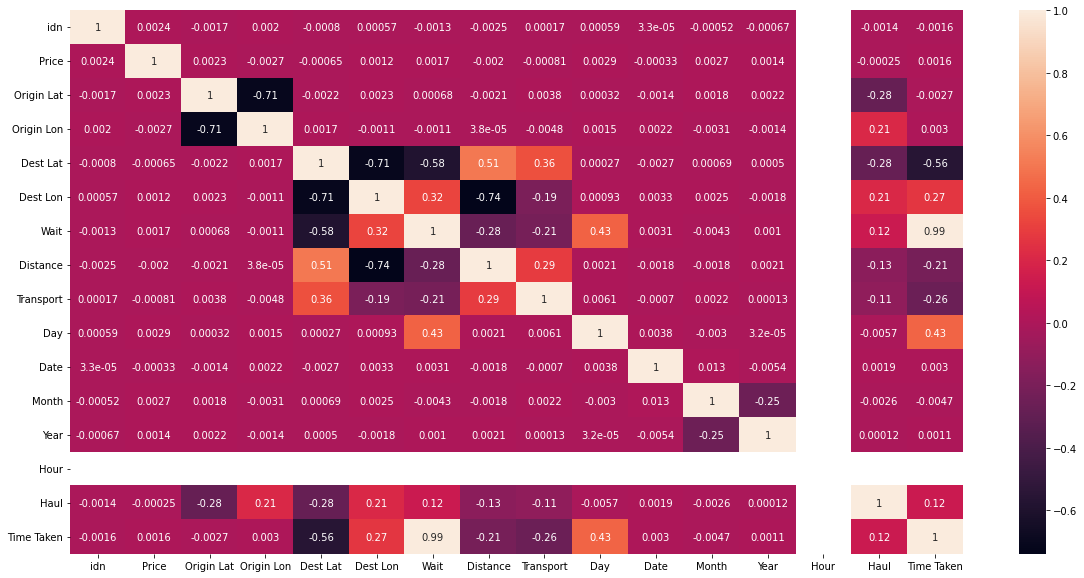

In [3]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(dataset.corr(), annot = True, ax=ax)


The below scatter graph shows that the distance between the terminal doesnt have much of an impact on the time taken. 


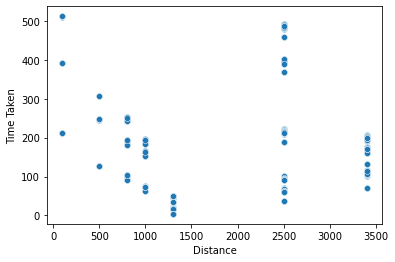

In [4]:
sns.scatterplot(x ="Distance", y="Time Taken", data = dataset)

The following scatter graph shows how wait time at the security directly correlates with the total wait time, which is as expected.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


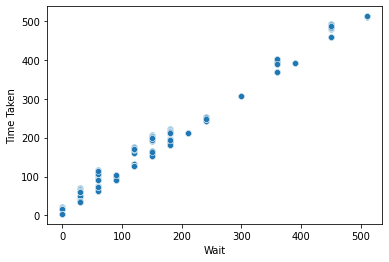

In [6]:
sns.scatterplot(dataset["Wait"], dataset["Time Taken"]);

###Importing and Cleaning the Data
We remove data that doesnt add any value to the model or has a low corrolation with the target. Features such as month, year and date values are removed.

In [9]:
checking_lat = np.array(dataset["Dest Lat"])
checking_lon  = np.array(dataset["Dest Lon"])
airport_lat = np.array(dataset_airport["latitude_deg"])
airport_lon = np.array(dataset_airport["longitude_deg"])
idxer = np.array(dataset_airport["identifier"])

other_dictionary = dict(zip(zip(airport_lat,airport_lon),idxer))

identifier_array = []
for x in range(len(checking_lon)):
    identifier_array.append(other_dictionary[checking_lat[x],checking_lon[x]])


In [10]:
dataset["Index"] = identifier_array
dataset.drop("Booking Number",axis = 1, inplace = True)
dataset.drop("idn",axis = 1, inplace = True)
dataset.drop("Dest Lat",axis = 1,inplace = True)
dataset.drop("Dest Lon",axis = 1, inplace = True)
dataset.drop("Year",axis = 1,inplace = True)
dataset.drop("Hour",axis = 1,inplace = True)
dataset.drop("Origin Lat",axis = 1, inplace = True)
dataset.drop("Origin Lon",axis = 1, inplace = True)
dataset.drop("Haul", axis = 1, inplace = True)

In [ ]:
dataset.tail()

,Price,Wait,Distance,Transport,Day,Date,Month,Time Taken,Index
199995,1501.59,60,1000,0,2,3,9,74,19442
199996,1473.75,450,2500,1,5,25,1,458,29613
199997,2210.82,0,1300,1,4,6,6,4,18873
199998,2422.92,210,100,0,2,22,9,212,57564
199999,1766.54,510,100,0,7,19,5,512,57564


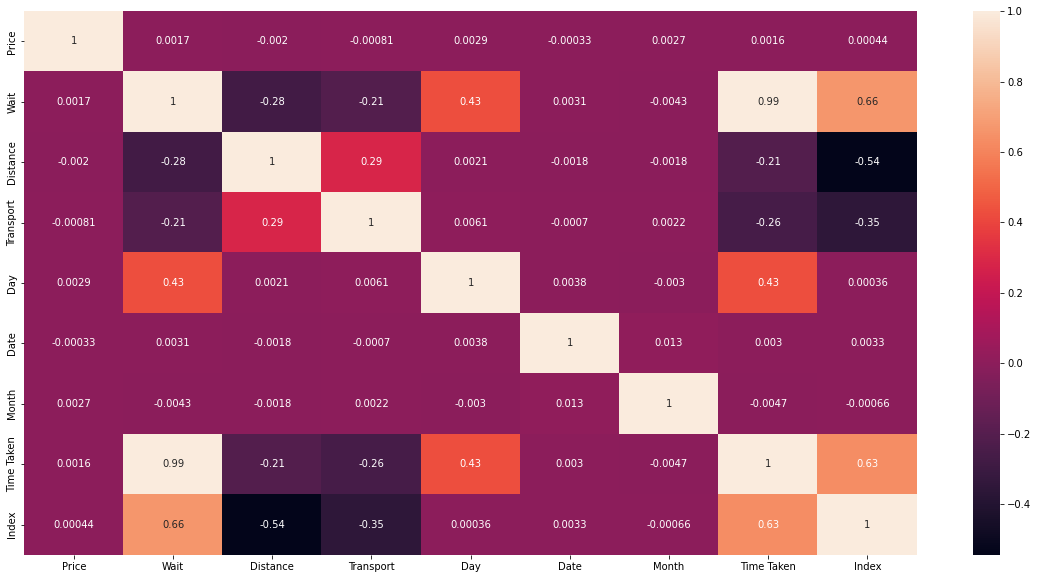

In [11]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(dataset.corr(), annot = True, ax=ax)

### The actual destination airport is encoded into the data file as it is a categorical data and we dont want the model to get confused.

In [17]:
index = dataset.pop("Index")
dataset["Airport1"] = (index == 29613)*1
dataset["Airport2"] = (index == 57564)*1
dataset["Airport3"] = (index == 17481)*1
dataset["Airport4"] = (index == 19442)*1
dataset["Airport5"] = (index == 19540)*1
dataset["Airport6"] = (index == 29933)*1
dataset["Airport7"] = (index == 18873)*1
dataset["Airport8"] = (index == 17467)*1

In [18]:
day = dataset.pop("Day")
dataset["Mon"] = (day == 1)*1
dataset["Tue"] = (day == 2)*1
dataset["Wed"] = (day == 3)*1
dataset["Thu"] = (day == 4)*1
dataset["Fri"] = (day == 5)*1
dataset["Sat"] = (day == 6)*1
dataset["Sun"] = (day == 7)*1

In [19]:
dataset.tail()

,Price,Wait,Distance,Transport,Date,Month,Time Taken,Airport1,Airport2,Airport3,Airport4,Airport5,Airport6,Airport7,Airport8,Mon,Tue,Wed,Thu,Fri,Sat,Sun
199995,1501.59,60,1000,0,3,9,74,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
199996,1473.75,450,2500,1,25,1,458,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
199997,2210.82,0,1300,1,6,6,4,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
199998,2422.92,210,100,0,22,9,212,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
199999,1766.54,510,100,0,19,5,512,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


**# Wait time through security and airport queues.**


This model is trained using DNN and the dataset that was presented in the challenge.

In [20]:
dataset1 = dataset.copy()
dataset1.drop("Price", axis = 1,inplace = True)
dataset1.drop("Transport",axis = 1, inplace = True)

In [21]:
dataset1.drop("Time Taken",axis = 1, inplace=True)

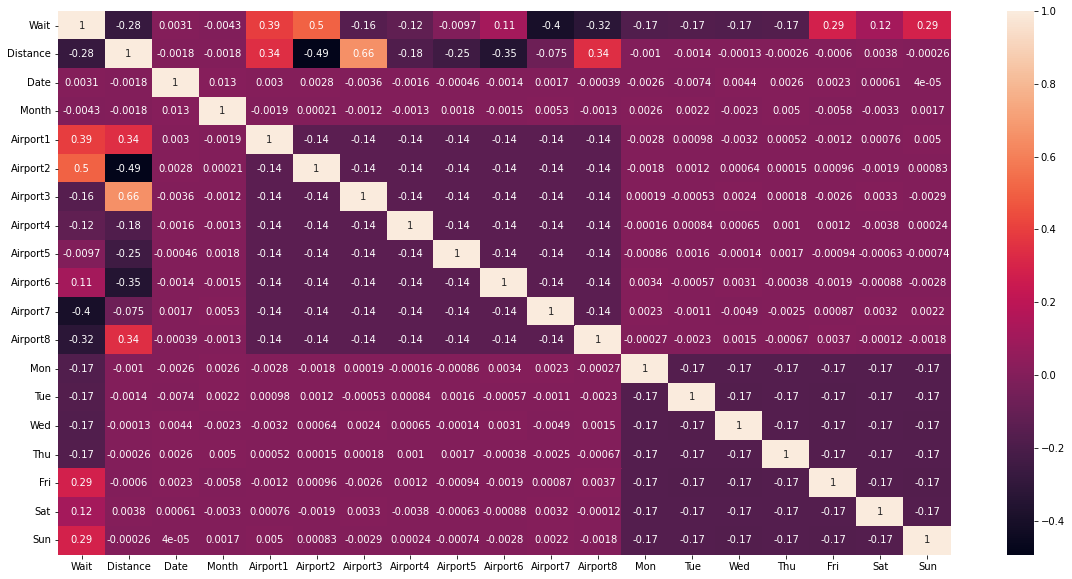

In [22]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(dataset1.corr(), annot = True, ax=ax)

In [23]:
#Split data into train and test
train_dataset1 = dataset1.sample(frac = 0.8, random_state = 0)
test_dataset1 = dataset1.drop(train_dataset1.index)

#split the data into features and labels.
train_features1 = train_dataset1.copy()
test_features1  = train_dataset1.copy()

train_labels1 = train_features1.pop("Wait")
test_labels1 = test_features1.pop("Wait")

#Normalization layer
normalizer = preprocessing.Normalization()

#adapt to data
normalizer.adapt(np.array(train_features1))

print(normalizer.mean.numpy())



[[1511.992   15.714    5.962    0.125    0.126    0.126    0.126    0.124
     0.125    0.125    0.124    0.143    0.143    0.144    0.143    0.144
     0.141    0.143]]


In [ ]:
loss = keras.losses.MeanAbsoluteError()
optim = keras.optimizers.Adam(lr=0.01)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#DNN
dnn_model_first = keras.Sequential([
            normalizer,
            layers.Dense(128,activation= "relu"),
            layers.Dense(65,activation = "relu"),
            layers.Dense(64,activation ="relu"),
            layers.Dense(64,activation = "relu"),
            layers.Dense(1)
])


In [ ]:
dnn_model_first.compile(loss = loss,optimizer = tf.keras.optimizers.Adam(0.001))
dnn_model_first.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 18)               37        
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 128)               2432      
                                                                 
 dense_16 (Dense)            (None, 65)                8385      
                                                                 
 dense_17 (Dense)            (None, 64)                4224      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                      

In [ ]:
dnn_model_first.fit(
    train_features1, train_labels1,
    validation_split=0.2,
    verbose=1, epochs=100#)

Epoch 1/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.6387 - val_loss: 0.3924
Epoch 2/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5903 - val_loss: 1.4935
Epoch 3/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5795 - val_loss: 0.7085
Epoch 4/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5474 - val_loss: 0.6710
Epoch 5/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5314 - val_loss: 0.3641
Epoch 6/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5318 - val_loss: 0.4208
Epoch 7/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5165 - val_loss: 1.5704
Epoch 8/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.5153 - val_loss: 0.1987
Epoch 9/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.4899 - val_loss: 0.2729
Epoch 10/100
4000/4000 [==============================] - 9s 2ms/step - l

In [ ]:
import os
!pip install pyyaml h5py
dnn_model_first.save("FirstHalf DNN nonv2 hd5")
dnn_model_first.save("FirstHalf DNN hd5v2.h5")

INFO:tensorflow:Assets written to: FirstHalf DNN nonv2 hd5/assets


In [ ]:
test_features1 = test_features1[:40000]
dnn_model_first.evaluate(test_features1,test_dataset1,verbose = 1)


1250/1250 [==============================] - 2s 2ms/step - loss: 212.4634


212.46339416503906

# Training for second part.

In [ ]:
dataset2 = dataset.copy()
dataset.tail()

,Price,Wait,Distance,Transport,Date,Month,Time Taken,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Airport1,Airport2,Airport3,Airport4,Airport5,Airport6,Airport7,Airport8
199995,1501.59,60,1000,0,3,9,74,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
199996,1473.75,450,2500,1,25,1,458,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
199997,2210.82,0,1300,1,6,6,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
199998,2422.92,210,100,0,22,9,212,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
199999,1766.54,510,100,0,19,5,512,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [ ]:
transport = dataset2.pop("Transport")
dataset2["Bus"] = (transport == 1)*1
dataset2["Walk"] = (transport == 0)*1

In [ ]:
dataset2.tail()

,Price,Wait,Distance,Date,Month,Time Taken,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Airport1,Airport2,Airport3,Airport4,Airport5,Airport6,Airport7,Airport8,Bus,Walk
199995,1501.59,60,1000,3,9,74,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
199996,1473.75,450,2500,25,1,458,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
199997,2210.82,0,1300,6,6,4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
199998,2422.92,210,100,22,9,212,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
199999,1766.54,510,100,19,5,512,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1


In [ ]:
dataset2["New time"] = dataset2["Time Taken"] - dataset2["Wait"]
dataset2.pop("Wait")
dataset2.pop("Time Taken")
dataset2.tail()

,Price,Distance,Date,Month,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Airport1,Airport2,Airport3,Airport4,Airport5,Airport6,Airport7,Airport8,Bus,Walk,New time
199995,1501.59,1000,3,9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,14
199996,1473.75,2500,25,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,8
199997,2210.82,1300,6,6,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,4
199998,2422.92,100,22,9,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
199999,1766.54,100,19,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2


In [ ]:
#Split data into train and test
train_dataset2 = dataset2.sample(frac = 0.8, random_state = 0)
test_dataset2 = dataset2.drop(train_dataset2.index)

#split the data into features and labels.
train_features2 = train_dataset2.copy()
test_features2  = train_dataset2.copy()

train_labels2 = train_features2.pop("New time")
test_labels2 = test_features2.pop("New time")
test_features2.tail()


,Price,Distance,Date,Month,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Airport1,Airport2,Airport3,Airport4,Airport5,Airport6,Airport7,Airport8,Bus,Walk
164955,696.25,1300,8,7,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
15299,2021.47,1000,30,9,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
55301,2352.83,1000,3,9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
125050,396.91,800,15,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
34309,2441.52,500,11,11,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
#Normalization layer
normalizer = preprocessing.Normalization()

#adapt to data
normalizer.adapt(np.array(train_features2))


loss = keras.losses.MeanAbsoluteError()
optim = keras.optimizers.Adam(lr=0.1)




#DNN
dnn_model2 = keras.Sequential([
            normalizer,
            layers.Dense(164,activation= "relu"),
            layers.Dense(65,activation = "relu"),
            layers.Dense(64,activation ="relu"),
            layers.Dense(64,activation ="relu"),

            layers.Dense(1)])



dnn_model2.compile(loss = loss,optimizer = tf.keras.optimizers.Adam(0.001))
dnn_model2.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 21)               43        
 ion)                                                            
                                                                 
 dense_20 (Dense)            (None, 164)               3608      
                                                                 
 dense_21 (Dense)            (None, 65)                10725     
                                                                 
 dense_22 (Dense)            (None, 64)                4224      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
dnn_model2.fit(
    train_features2, train_labels2,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8953 - val_loss: 0.9383
Epoch 2/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8975 - val_loss: 0.9012
Epoch 3/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8937 - val_loss: 0.9052
Epoch 4/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8925 - val_loss: 0.9033
Epoch 5/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8938 - val_loss: 0.8862
Epoch 6/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8893 - val_loss: 0.8859
Epoch 7/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8873 - val_loss: 0.8872
Epoch 8/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8854 - val_loss: 0.8899
Epoch 9/100
4000/4000 [==============================] - 9s 2ms/step - loss: 0.8858 - val_loss: 0.8946
Epoch 10/100
4000/4000 [==============================] - 9s 2ms/step - l

In [ ]:
test_features2 = test_features2[:40000]
print(test_features2.tail())
dnn_model2.evaluate(test_features2,test_dataset2,verbose = 1)

          Price  Distance  Date  Month  ...  Airport7  Airport8  Bus  Walk
170313   431.98      2500    23      2  ...         0         1    0     1
131592   244.53      2500    28      9  ...         0         1    1     0
8394    1377.52      2500    14     11  ...         0         1    0     1
147183    69.02      2500    30      9  ...         0         1    1     0
15138    147.33      2500    21      2  ...         0         0    1     0

[5 rows x 21 columns]
1250/1250 [==============================] - 2s 2ms/step - loss: 137.3133


137.3133087158203

In [ ]:
dnn_model_first.save("SecondHalf DNN nonv2 hd5")
dnn_model_first.save("SecondHalf DNN hd5v2.h5")

The total combined loss (when the two functions are added in quadrature) is 250,
which is within the acceptable boundaries of the problem, an error of approximately 10minutes. 